In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary

import PIL
import shutil
import zipfile
import glob
import os
import time
import random
import timm


데이터 파싱

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataDir = './dataset/AI-DATASET/data'

trainData_dir = os.path.join(dataDir, 'trainData')
train_dir = os.path.join(dataDir, 'train')
test_dir = os.path.join(dataDir, 'test')

# train, test 폴더 생성
train_set_dir = os.path.join(train_dir, 'train')
test_set_dir = os.path.join(train_dir, 'test')


데이터셋 설정

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'beverage_can' in files[0]:
            self.label = 0
        elif 'beverage_bottle' in files[0]:
            self.label = 1
        elif 'noodle_bag' in files[0]:
            self.label = 2
        elif 'noodle_cup' in files[0]:
            self.label = 3
        elif 'beverage_milk' in files[0]:
            self.label = 4
        elif 'icecream' in files[0]:
            self.label = 5
        else:
            self.label = 6


    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

데이터 전처리

In [12]:

# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_datasets = torchvision.datasets.ImageFolder(os.path.join(train_set_dir), transforms_train)
test_datasets = torchvision.datasets.ImageFolder(os.path.join(test_set_dir), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)



학습 데이터셋 크기: 2800
테스트 데이터셋 크기: 700
클래스: ['beverage_bottle', 'beverage_can', 'beverage_milk', 'iceCream', 'noodle_bag', 'noodle_cup', 'snack_bag']


사용할 모델

In [13]:
model = torchvision.models.resnet34(weights=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 n개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 7)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

c:\Users\kde96\.conda\envs\PyeonHaeng\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


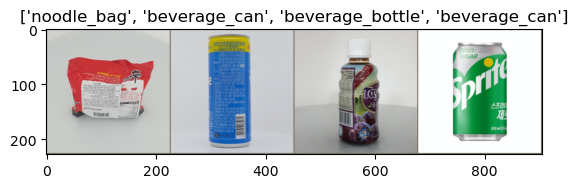

In [14]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


In [15]:
num_epochs = 10
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.5202 Acc: 82.0000% Time: 73.7354s
#1 Loss: 0.2374 Acc: 92.1429% Time: 139.9914s
#2 Loss: 0.1342 Acc: 95.8214% Time: 206.3651s
#3 Loss: 0.0828 Acc: 97.7143% Time: 274.4380s
#4 Loss: 0.0477 Acc: 98.4643% Time: 341.5946s
#5 Loss: 0.0425 Acc: 98.7500% Time: 409.7651s
#6 Loss: 0.0506 Acc: 98.7857% Time: 476.9372s
#7 Loss: 0.0238 Acc: 99.1071% Time: 542.7651s
#8 Loss: 0.0309 Acc: 99.2857% Time: 609.7042s
#9 Loss: 0.0161 Acc: 99.5000% Time: 675.6072s
